# Experiments on CIFAR-100

In [1]:
# Try to keep all imports in this cell

import torch
import torchvision.datasets
import numpy as np
import pandas as pd
import os
import sklearn.pipeline
import sklearn.linear_model
import sklearn.random_projection
import matplotlib.pyplot as plt
import scipy
import IPython
import random

try:
    import text_extensions_for_pandas as tp
except ModuleNotFoundError:
    raise Exception("text_extensions_for_pandas package not found on the Jupyter "
                    "kernel's path. Please either run:\n"
                    "   ln -s ../../text_extensions_for_pandas .\n"
                    "from the directory containing this notebook, or use a Python "
                    "environment on which you have used `pip` to install the package.")

# Keep the inputs and outputs of this script in their own subdirectories.
OUTPUT_DIR = "outputs/cifar100"
DATA_DIR = "data/cifar100"
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

## Load the data set

In [2]:
# Grab the data set
cifar100_train = torchvision.datasets.CIFAR100(DATA_DIR, train=True, download=True)
cifar100_test = torchvision.datasets.CIFAR100(DATA_DIR, train=False, download=True)
cifar100_test

Files already downloaded and verified
Files already downloaded and verified


Dataset CIFAR100
    Number of datapoints: 10000
    Root location: data/cifar100
    Split: Test

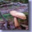

In [3]:
# PyTorch Dataset objects store images with PIL.
image, label = cifar100_test[3]
image

In [4]:
label, cifar100_train.classes[label]

(51, 'mushroom')

In [5]:
# We'll need this number later on.
num_classes = len(cifar100_train.classes)
num_classes

100

## Load and run pretrained model

In [6]:
# Grab a pretrained model from https://github.com/chenyaofo/pytorch-cifar-models
model_repo_name = "chenyaofo/pytorch-cifar-models"
print(f"Available models:\n{torch.hub.list(model_repo_name)}")

# This model gets 75.98% top-1 and 93.44% top-5 accuracy on CIFAR-100.
model_name_core = "mobilenetv2_x1_4"

# Alternate model: VGG19. Much slower with similar accuracy to the
# mobilenetv2_x1_4 model, but closer in structure to the model used 
# in previous work.
# model_name_core = "repvgg_a2"

# model_name_core = "resnet20"

model_name = f"cifar100_{model_name_core}"

print(f"Using model: {model_name}")

model = torch.hub.load(model_repo_name, model_name, pretrained=True)
_ = model.eval()  # VERY IMPORTANT. Turns off dropout.

Using cache found in /Users/freiss/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /Users/freiss/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Available models:
['cifar100_mobilenetv2_x0_5', 'cifar100_mobilenetv2_x0_75', 'cifar100_mobilenetv2_x1_0', 'cifar100_mobilenetv2_x1_4', 'cifar100_repvgg_a0', 'cifar100_repvgg_a1', 'cifar100_repvgg_a2', 'cifar100_resnet20', 'cifar100_resnet32', 'cifar100_resnet44', 'cifar100_resnet56', 'cifar100_shufflenetv2_x0_5', 'cifar100_shufflenetv2_x1_0', 'cifar100_shufflenetv2_x1_5', 'cifar100_shufflenetv2_x2_0', 'cifar100_vgg11_bn', 'cifar100_vgg13_bn', 'cifar100_vgg16_bn', 'cifar100_vgg19_bn', 'cifar100_vit_b16', 'cifar100_vit_b32', 'cifar100_vit_h14', 'cifar100_vit_l16', 'cifar100_vit_l32', 'cifar10_mobilenetv2_x0_5', 'cifar10_mobilenetv2_x0_75', 'cifar10_mobilenetv2_x1_0', 'cifar10_mobilenetv2_x1_4', 'cifar10_repvgg_a0', 'cifar10_repvgg_a1', 'cifar10_repvgg_a2', 'cifar10_resnet20', 'cifar10_resnet32', 'cifar10_resnet44', 'cifar10_resnet56', 'cifar10_shufflenetv2_x0_5', 'cifar10_shufflenetv2_x1_0', 'cifar10_shufflenetv2_x1_5', 'cifar10_shufflenetv2_x2_0', 'cifar10_vgg11_bn', 'cifar10_vgg13_bn'

In [7]:
# Metadata required for inference, from
# https://github.com/chenyaofo/image-classification-codebase/blob/master/conf/cifar100.conf
image_size = 32
rgb_means = [0.5070, 0.4865, 0.4409]
rgb_stdevs = [0.2673, 0.2564, 0.2761]

# See https://github.com/chenyaofo/image-classification-codebase/blob/master/codebase/data/cifar.py
def preprocess_image(img) -> torch.Tensor:
    img_tensor = torchvision.transforms.ToTensor()(img)
    img_tensor = torchvision.transforms.Normalize(mean=rgb_means, std=rgb_stdevs)(img_tensor)
    img_tensor = img_tensor.unsqueeze(0) # Convert to singleton batch
    return img_tensor

In [8]:
# Run an image through the model to verify it's loaded correctly
image_tensor = preprocess_image(image)
with torch.inference_mode():
    logits = model(image_tensor)[0]
    probs = torch.nn.functional.softmax(logits, dim=0)
print(f"Class Probabilities:\n{probs}")
print(f"Probability of corpus label: {probs[label]} at {label} "
      f"({cifar100_train.classes[label]})")
print(f"            Max probability: {torch.max(probs)} at {torch.argmax(probs)} "
      f"({cifar100_train.classes[torch.argmax(probs)]})")

Class Probabilities:
tensor([8.5950e-06, 4.6022e-05, 6.5347e-07, 1.6395e-05, 3.0538e-06, 6.4615e-07,
        1.4084e-06, 1.7868e-06, 1.8923e-06, 2.5074e-05, 5.1697e-06, 8.7581e-06,
        2.6024e-06, 8.9292e-07, 1.6432e-06, 6.3570e-06, 2.0365e-04, 1.4186e-05,
        9.5952e-05, 1.5198e-05, 3.2176e-05, 4.2045e-06, 3.0191e-05, 1.2927e-06,
        2.3027e-05, 4.4596e-06, 1.5781e-05, 2.5413e-06, 7.8990e-06, 3.8344e-05,
        2.3863e-05, 7.8507e-05, 3.3953e-05, 8.2356e-05, 1.8366e-05, 5.1161e-06,
        3.1476e-07, 1.0010e-03, 7.3645e-05, 2.4696e-06, 1.0808e-04, 1.4148e-06,
        1.9303e-06, 2.0691e-06, 3.1149e-05, 3.5173e-06, 1.3798e-05, 7.9174e-07,
        5.0428e-06, 3.7497e-06, 2.7426e-06, 9.9217e-01, 6.1359e-08, 1.3346e-06,
        4.7322e-05, 1.8139e-06, 8.0463e-06, 3.1280e-06, 7.9280e-07, 7.6722e-06,
        3.4295e-07, 3.6008e-06, 1.1946e-06, 1.7977e-06, 2.0841e-05, 2.9919e-05,
        5.7613e-06, 5.3407e-06, 9.6131e-07, 3.8248e-06, 3.0532e-06, 1.0396e-06,
        6.8870e-06,

In [9]:
# Add a forward hook to retreive activations of the model from the
# layer before the classifier
activation = {}


def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


model.features.register_forward_hook(get_activation("features"))

In [10]:
def image_to_features(img) -> np.ndarray:
    """
    Run an image through the model and retrieve the resulting classifier
    input features.

    :param img: PIL image object
    :returns: Tuple with:
     * Features for the image as a 1D NumPy array
     * Final outputs of the model (class probabilities) as a 1D NumPy array
    """
    with torch.inference_mode():
        # Construct a singleton batch and run it through the model.
        # This is not the most efficient way to do this, but the model's pretty
        # fast and we only have to do this operation once.
        img_tensor = preprocess_image(img)

        logits = model.forward(img_tensor)
        logits = torch.flatten(logits)

        # Convert logits to probabilities by running them through softmax
        probs = torch.nn.functional.softmax(logits, dim=0)

        # Alternate approach: Treat logits as the actual results of running 
        # probabilities through the logistic function.
        # probs = torch.special.expit(logits)
        # probs /= probs.sum()

        # Retrieve the features, which are 4x4-dimensional, and average pool them
        # down as the underlying model does.
        # `activation` is the dictionary that our callback uses.
        features = activation["features"]
        features = torch.nn.functional.adaptive_avg_pool2d(features, (1, 1))
        features = torch.flatten(features)
        return (features.detach().numpy(), probs.detach().numpy())


image_to_features(image)

(array([0.03481359, 0.04923873, 0.3056193 , ..., 0.17622763, 0.22800577,
        0.22937879], dtype=float32),
 array([8.5950114e-06, 4.6022476e-05, 6.5346967e-07, 1.6395146e-05,
        3.0538101e-06, 6.4614551e-07, 1.4084287e-06, 1.7867670e-06,
        1.8922734e-06, 2.5073919e-05, 5.1696593e-06, 8.7580738e-06,
        2.6023677e-06, 8.9291973e-07, 1.6432158e-06, 6.3570187e-06,
        2.0364657e-04, 1.4186463e-05, 9.5952470e-05, 1.5197619e-05,
        3.2175813e-05, 4.2045472e-06, 3.0190857e-05, 1.2927366e-06,
        2.3026574e-05, 4.4595604e-06, 1.5781352e-05, 2.5412742e-06,
        7.8990442e-06, 3.8343620e-05, 2.3862558e-05, 7.8507052e-05,
        3.3953398e-05, 8.2355939e-05, 1.8366072e-05, 5.1161255e-06,
        3.1475784e-07, 1.0009931e-03, 7.3644842e-05, 2.4696026e-06,
        1.0808380e-04, 1.4148462e-06, 1.9303461e-06, 2.0691036e-06,
        3.1148567e-05, 3.5173248e-06, 1.3797635e-05, 7.9174265e-07,
        5.0427675e-06, 3.7496616e-06, 2.7426463e-06, 9.9217248e-01,
      

In [11]:
def maybe_generate_features(data_set: torch.utils.data.Dataset, cache_path: str):
    """
    If a result is available in the indicated cache file, load it into 
    a DataFrame. Otherwise, run all the images in a data set through the
    model's lower layers to generate feature vectors for the classifier 
    and write the resulting DataFrame of features and labels to the 
    cache location.

    :param data_set: Input set of images. Image should be element 0 of each
    tuple in the data set.
    :param cache_path: Path at which the resulting features DataFrame should
     be cached.
    """
    if not os.path.exists(cache_path):
        features_list = []
        labels_list = []
        probs_list = []
        for image, label in data_set:
            features, probs = image_to_features(image)
            features_list.append(features)
            labels_list.append(label)
            probs_list.append(probs)

        df = pd.DataFrame({
            "id": range(len(features_list)),
            "features": pd.Series(features_list, dtype=tp.TensorDtype()),
            "probs": pd.Series(probs_list, dtype=tp.TensorDtype()),
            "label": labels_list
        })
        df.to_parquet(cache_path)
    return pd.read_parquet(cache_path)

In [12]:
%%time
# This takes about 2 minutes if the results aren't cached.
test = maybe_generate_features(cifar100_test, f"{OUTPUT_DIR}/cifar100_test.parquet")
test

CPU times: user 1.21 s, sys: 157 ms, total: 1.37 s
Wall time: 342 ms


,id,features,probs,label
0,0,"[ 0.18307097, 0.013836535, 0.04344034...","[ 0.0010504944, 9.413256e-05, 0.001838636...",49
1,1,"[ 0.23108834, 0.096513025, 0.003626135...","[ 2.0701887e-06, 9.870547e-06, 3.5172136e-0...",33
2,2,"[ 0.13319004, 0.36743766, 0.474158...","[ 7.419712e-07, 5.3416475e-08, 3.706408e-0...",72
3,3,"[ 0.03481356, 0.04923868, 0.3056191...","[ 8.595003e-06, 4.602239e-05, 6.5346904e-0...",51
4,4,"[ 0.19876105, 0.31993148, 0....","[ 4.0264777e-07, 3.3833164e-08, 2.3356885e-0...",71
...,...,...,...,...
9995,9995,"[ 0.08025868, 0.13432066, 0....","[ 0.07103336, 7.0743736e-06, 9.687936e-0...",83
9996,9996,"[ 0.24039556, 0.51754326, 0.1014616...","[ 1.4445293e-06, 5.2155083e-05, 0.0001052426...",14
9997,9997,"[ 0.10530074, 0.0039510024, 0.2609685...","[ 2.4445411e-08, 1.1145442e-08, 3.7830855e-1...",51
9998,9998,"[ 0.17295003, 0.45424968, 0.0785808...","[ 1.7262602e-06, 5.5876797e-07, 5.9284145e-0...",42


In [13]:
%%time
# This takes about 12 minutes if the results aren't cached.
train = maybe_generate_features(cifar100_train, f"{OUTPUT_DIR}/cifar100_train.parquet")
train

CPU times: user 927 ms, sys: 554 ms, total: 1.48 s
Wall time: 1.44 s


,id,features,probs,label
0,0,"[ 0.36490348, 0.0, 0.0673169...","[ 6.738046e-08, 1.8206116e-06, 0.00010795741...",19
1,1,"[ 0.03197602, 0.022291945, 0.768758...","[ 2.1781175e-09, 6.609471e-07, 1.7673889e-0...",29
2,2,"[ 0.17250007, 0.27478674, 0.02727457...","[ 0.9984798, 1.2893012e-06, 1.412936e-0...",0
3,3,"[ 0.0, 0.22109374, 0.08527192...","[ 8.002939e-08, 5.916073e-09, 5.6585725e-0...",11
4,4,"[ 0.029140279, 0.0, 1.018488...","[ 3.693531e-09, 0.9999964, 1.9768387e-0...",1
...,...,...,...,...
49995,49995,"[ 0.8828023, 0.08167683, 0.05827973...","[ 2.448151e-10, 2.643886e-08, 3.5246466e-0...",80
49996,49996,"[ 0.4152848, 0.0, 0.567196...","[ 2.0944965e-08, 1.6520039e-07, 6.7082175e-0...",7
49997,49997,"[ 0.0, 0.42848706, 0.053374...","[1.04876236e-07, 1.862563e-07, 2.3115113e-0...",3
49998,49998,"[ 0.15001081, 0.15990685, 0.1853563...","[ 3.4555305e-05, 5.975771e-05, 9.476925e-0...",7


## Train reduced-capacity models

In [14]:
%%time
# Train a multinomial logistic regression model on the training set.
_MULTI_CLASS = "multinomial"
_SOLVER, _SOLVER_LOG_LEVEL = ("lbfgs", 0)
#_SOLVER, _SOLVER_LOG_LEVEL = ("saga", 1)


# (from docs) "Inverse of regularization strength; must be a positive float. 
# Like in support vector machines, smaller values specify stronger regularization."
# Default values
#_REGULARIZATION_TYPE, _REGULARIZATION_COEFF = ("l2", 1e0)

# Super fast convergence, good accuracy, artificially low confidence
#_REGULARIZATION_TYPE, _REGULARIZATION_COEFF = ("l2", 1e-5)

# L1-regularlized: takes forever to converge, no improvement in accuracy
#_REGULARIZATION_TYPE, _REGULARIZATION_COEFF = ("l1", 1e0)

# This value produces a model where the average top-1 probability is
# roughly equal to the top-1 accuracy.
#_REGULARIZATION_TYPE, _REGULARIZATION_COEFF = ("l2", 7e-3)

# This value produces a model with a nice straight calibration curve,
# without any calibration
_REGULARIZATION_TYPE, _REGULARIZATION_COEFF = ("l2", 1e-2)

# TEMPORARY: Try a bit more regularization to see how the calibration curve of the
# training set goes.
#_REGULARIZATION_TYPE, _REGULARIZATION_COEFF = ("l2", 1e-5)

def train_base_model(df: pd.DataFrame,
                     regularization_type=_REGULARIZATION_TYPE,
                     regularization_coeff=_REGULARIZATION_COEFF) -> sklearn.base.BaseEstimator:  
    base_pipeline = sklearn.pipeline.Pipeline([
        # Standard scaler. This only makes a difference for certain classes
        # of embeddings.
        #("scaler", sklearn.preprocessing.StandardScaler()),
        ("mlogreg", sklearn.linear_model.LogisticRegression(
            multi_class=_MULTI_CLASS,
            max_iter=1000,
            verbose=_SOLVER_LOG_LEVEL,
            penalty=regularization_type,
            C=regularization_coeff,
            solver=_SOLVER))
    ])
    return base_pipeline.fit(df["features"].values, df["label"])

def train_reduced_model(df: pd.DataFrame,
                        n_components: int, 
                        seed: int=42,
                        regularization_type=_REGULARIZATION_TYPE,
                        regularization_coeff=_REGULARIZATION_COEFF) -> sklearn.base.BaseEstimator:
    pipeline = sklearn.pipeline.Pipeline([
        # Standard scaler. This only makes a difference for certain classes
        # of embeddings.
        #("scaler", sklearn.preprocessing.StandardScaler()),
        ("dimred", sklearn.random_projection.GaussianRandomProjection(
                n_components=n_components, random_state=seed)),
        ("mlogreg", sklearn.linear_model.LogisticRegression(
            multi_class=_MULTI_CLASS,
            max_iter=1000,
            verbose=_SOLVER_LOG_LEVEL,
            penalty=regularization_type,
            C=regularization_coeff,
            solver=_SOLVER))
    ])
    return pipeline.fit(df["features"].values, df["label"])
    

base_model = train_base_model(train)

CPU times: user 7min 30s, sys: 33.2 s, total: 8min 3s
Wall time: 46.1 s


In [15]:
# Eyeball some top-1 results from the original model

def add_top_k_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    probs_array = df["probs"].array.to_numpy()
    num_examples = len(df.index)

    df["label_prob"] = probs_array[range(num_examples), df["label"].to_numpy()]
    df["top1"] = np.argmax(probs_array, axis=1)
    df["top1_prob"] = np.max(probs_array, axis=1)
    df["top5"] = tp.TensorArray(np.flip(np.argsort(probs_array)[:,-5:], axis=1))
    top5_mask = (
        np.any(
            np.equal(df["top5"].values, df["label"].values.reshape((-1,1))),
            axis=1)
    )
    df["top5_match"] = pd.Series(top5_mask, dtype=bool)
    return df


orig_results = add_top_k_cols(test[["id", "probs", "label"]])

orig_results.head(10)

,id,probs,label,label_prob,top1,top1_prob,top5,top5_match
0,0,"[ 0.0010504944, 9.413256e-05, 0.001838636...",49,0.004306,90,0.335517,"[90, 60, 69, 68, 55]",False
1,1,"[ 2.0701887e-06, 9.870547e-06, 3.5172136e-0...",33,0.946687,33,0.946687,"[33, 84, 88, 40, 9]",True
2,2,"[ 7.419712e-07, 5.3416475e-08, 3.706408e-0...",72,0.023260,55,0.852407,"[55, 4, 72, 3, 27]",True
3,3,"[ 8.595003e-06, 4.602239e-05, 6.5346904e-0...",51,0.992172,51,0.992172,"[51, 91, 37, 73, 77]",True
4,4,"[ 4.0264777e-07, 3.3833164e-08, 2.3356885e-0...",71,0.994167,71,0.994167,"[71, 23, 60, 82, 96]",True
5,5,"[ 6.44879e-06, 1.875078e-05, 4.5642587e-0...",92,0.001465,7,0.927225,"[ 7, 79, 24, 6, 14]",False
6,6,"[ 4.1170148e-07, 5.845992e-05, 3.09706e-0...",15,0.748704,15,0.748704,"[15, 29, 31, 27, 85]",True
7,7,"[ 1.0067877e-06, 2.7181803e-05, 5.1803668e-0...",14,0.535528,14,0.535528,"[14, 63, 75, 74, 79]",True
8,8,"[ 4.739807e-07, 1.7587921e-07, 1.7107781e-0...",23,0.007730,71,0.991327,"[71, 23, 60, 49, 12]",True
9,9,"[ 0.47669974, 3.9131068e-05, 0.0001874159...",0,0.476700,57,0.497938,"[57, 0, 83, 53, 92]",True


In [16]:
# Compute top-1 accuracy
num_correct = (orig_results["label"] == orig_results["top1"]).sum()
top_1_acc = num_correct / len(orig_results.index)
top_1_acc

0.7629

In [17]:
# Look at top-1 results from the sklearn model we just trained
def make_results(data: pd.DataFrame, model: sklearn.base.BaseEstimator) -> pd.DataFrame:
    df = data[["id", "label"]].copy()
    df["probs"] = tp.TensorArray(model.predict_proba(data["features"].values))
    df = add_top_k_cols(df[["id", "probs", "label"]])
    return df


base_results = make_results(test, base_model)
base_results.head(10)

,id,probs,label,label_prob,top1,top1_prob,top5,top5_match
0,0,"[ 0.005854557127795873, 0.001044076868371778...",49,0.012577,90,0.150746,"[90, 69, 60, 68, 55]",False
1,1,"[ 9.559308234828802e-05, 0.000254882639461478...",33,0.836550,33,0.836550,"[33, 84, 88, 40, 81]",True
2,2,"[ 8.761981268529843e-05, 1.5968990653538752e-0...",72,0.036595,55,0.769059,"[55, 4, 72, 3, 27]",True
3,3,"[ 0.0003684075279662523, 0.000954082237377838...",51,0.916458,51,0.916458,"[51, 91, 37, 73, 77]",True
4,4,"[0.00011528890187400213, 1.0516887165878677e-0...",71,0.973617,71,0.973617,"[71, 23, 60, 82, 5]",True
5,5,"[ 0.0006221577881041749, 0.000735041111398788...",92,0.009720,7,0.723193,"[ 7, 79, 24, 6, 14]",False
6,6,"[ 7.738071142873756e-05, 0.000895176135994743...",15,0.557472,15,0.557472,"[15, 29, 27, 85, 31]",True
7,7,"[ 0.0001074332463597663, 0.000481291928853394...",14,0.425870,14,0.425870,"[14, 63, 74, 75, 79]",True
8,8,"[0.00011774629461566955, 3.244943231821209e-0...",23,0.021130,71,0.960087,"[71, 23, 60, 49, 69]",True
9,9,"[ 0.48011297929838725, 0.000514526585301943...",0,0.480113,0,0.480113,"[ 0, 57, 83, 53, 92]",True


In [18]:
# Compute top-1 accuracy
num_correct = (base_results["label"] == base_results["top1"]).sum()
top_1_acc = num_correct / len(base_results.index)
top_1_acc

0.7602

In [19]:
# Generate a report on the training set.
base_train_results = make_results(train, base_model)

# Take a peek at elements of the training set that ended up with low confidence
low_confidence_but_correct = base_train_results[base_train_results["top1_prob"] < 0.4]
low_confidence_but_correct

,id,probs,label,label_prob,top1,top1_prob,top5,top5_match
9446,9446,"[ 0.0003272813447355605, 0.000899724838374340...",80,0.394444,80,0.394444,"[80, 50, 74, 76, 31]",True
16859,16859,"[ 0.0017786041015523356, 0.00366246804370483...",51,0.346758,51,0.346758,"[51, 47, 28, 20, 4]",True
19598,19598,"[ 0.008480774233666014, 0.002821081815440394...",41,0.256684,41,0.256684,"[41, 89, 48, 58, 10]",True
20144,20144,"[ 0.0010523060059382005, 0.001928224575289976...",24,0.323389,24,0.323389,"[24, 7, 26, 14, 93]",True
32814,32814,"[ 0.003201033186279686, 0.003471017335032799...",90,0.391521,90,0.391521,"[90, 81, 18, 59, 9]",True
38608,38608,"[ 0.008979066802843364, 0.001021024177296173...",14,0.345245,14,0.345245,"[14, 57, 74, 50, 7]",True
40712,40712,"[0.00029675627374902043, 0.002592791588236...",44,0.334554,44,0.334554,"[44, 78, 33, 8, 51]",True


In [20]:
def result_report(df: pd.DataFrame, fold_data, index_id: int):
    """
    Generate a report on a particular model result.

    :param df: DataFrame of model results as returned by `make_results()`.
     Must have the following columns:
     * `id`: Index into `fold_data` of the input data element
     * `top5`: Top 5 results from the model
     * `label`: Label from the source data, for validation
    :param fold_data:  Data structure containing source data for the fold.
    :param index_id: Value of the index of `df` for the row containing
     the result in question.
    """
    row = df.loc[index_id]
    element_id = row["id"]
    image, label = fold_data[element_id]

    # Sanity check: Make sure the labels match up
    if label != row["label"]:
        raise ValueError(f"Labels don't match ({label} != {row['label']}")

    top5 = row["top5"].to_numpy()
    print(f"Image {element_id}:")
    IPython.display.display(IPython.display.Image(data=image._repr_png_()))
    print(f"Corpus label: {label} ==> {cifar100_train.classes[label]}")
    print(f"Top 5 results: {top5} ==> {[cifar100_train.classes[l] for l in top5]}")


# for idx in low_confidence_but_correct.index:
#     result_report(low_confidence_but_correct, cifar100_train, idx)

Image 8393:


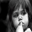

Corpus label: 35 ==> girl
Top 5 results: [ 2 35 11 73 97] ==> ['baby', 'girl', 'boy', 'shark', 'wolf']
Image 12702:


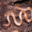

Corpus label: 99 ==> worm
Top 5 results: [78 99 51 31 43] ==> ['snake', 'worm', 'mushroom', 'elephant', 'lion']
Image 13523:


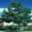

Corpus label: 52 ==> oak_tree
Top 5 results: [96 52 37 47 36] ==> ['willow_tree', 'oak_tree', 'house', 'maple_tree', 'hamster']
Image 16646:


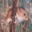

Corpus label: 50 ==> mouse
Top 5 results: [74 50  2  4 24] ==> ['shrew', 'mouse', 'baby', 'beaver', 'cockroach']
Image 17688:


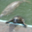

Corpus label: 72 ==> seal
Top 5 results: [55 72 30  3 18] ==> ['otter', 'seal', 'dolphin', 'bear', 'caterpillar']
Image 17976:


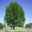

Corpus label: 52 ==> oak_tree
Top 5 results: [47 52 96 59 33] ==> ['maple_tree', 'oak_tree', 'willow_tree', 'pine_tree', 'forest']
Image 18461:


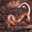

Corpus label: 78 ==> snake
Top 5 results: [99 78 74 29 26] ==> ['worm', 'snake', 'shrew', 'dinosaur', 'crab']
Image 27737:


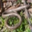

Corpus label: 78 ==> snake
Top 5 results: [99 78 22 91 18] ==> ['worm', 'snake', 'clock', 'trout', 'caterpillar']
Image 29268:


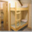

Corpus label: 5 ==> bed
Top 5 results: [94  5 20 86 25] ==> ['wardrobe', 'bed', 'chair', 'telephone', 'couch']
Image 30418:


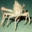

Corpus label: 79 ==> spider
Top 5 results: [26 79 20 44  6] ==> ['crab', 'spider', 'chair', 'lizard', 'bee']
Image 31128:


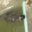

Corpus label: 72 ==> seal
Top 5 results: [55 72 75 66  4] ==> ['otter', 'seal', 'skunk', 'raccoon', 'beaver']
Image 31227:


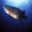

Corpus label: 95 ==> whale
Top 5 results: [73 95 93 67 30] ==> ['shark', 'whale', 'turtle', 'ray', 'dolphin']
Image 33638:


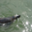

Corpus label: 55 ==> otter
Top 5 results: [72 55  3 18  4] ==> ['seal', 'otter', 'bear', 'caterpillar', 'beaver']


In [21]:
# Also check the elements the model got wrong on the training set
wrong_train_results = base_train_results[base_train_results["top1"] != base_train_results["label"]]
for idx in wrong_train_results.index:
    result_report(wrong_train_results, cifar100_train, idx)

In [22]:
# Generate raw data for determining how well-calibrated the model's probabilities are 
def make_calibration_data(df: pd.DataFrame) -> pd.DataFrame:
    target_bin_size = 100
    num_bins = len(df.index) * num_classes //  target_bin_size

    # Shred the probability distributions and generate triples of
    # <predicted label, probability of label, actual label>
    triples_list = []
    for probs, label in zip(df["probs"], df["label"]):
        for predicted_label in range(num_classes):
            prob = probs.to_numpy()[predicted_label]
            triples_list.append({
                "prediction": predicted_label,
                "prob": prob,
                "label": label
            })

    calib = pd.DataFrame.from_records(triples_list)

    # Tack on a 0/1 indicator variable that is 1 if the predicted and actual
    # labels are the same
    calib["is_correct"] = (calib["prediction"] == calib["label"]).astype(int)

    # Divide the range from 0 to 1 into bins
#     bin_left_edges = np.linspace(0., 1., num_bins + 1)
#     calib["prob_bin"] = pd.cut(calib["prob"], bin_left_edges, include_lowest=True)
    calib["prob_bin"] = pd.qcut(calib["prob"], num_bins)
    return calib


make_calibration_data(base_results)

,prediction,prob,label,is_correct,prob_bin
0,0,0.005855,49,0,"(0.0058479, 0.0058586]"
1,1,0.001044,49,0,"(0.0010437, 0.0010446]"
2,2,0.005334,49,0,"(0.0053338, 0.0053434]"
3,3,0.005427,49,0,"(0.0054236, 0.0054322]"
4,4,0.012450,49,0,"(0.012435, 0.01248]"
...,...,...,...,...,...
999995,95,0.000089,70,0,"(8.9317e-05, 8.9394e-05]"
999996,96,0.000011,70,0,"(1.1063e-05, 1.1077e-05]"
999997,97,0.000005,70,0,"(4.6447e-06, 4.6535e-06]"
999998,98,0.000023,70,0,"(2.3374e-05, 2.3401e-05]"


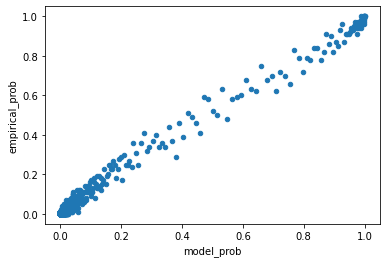

In [23]:
# Plot how well the example model is calibrated
def calibration_plot(df):
    (make_calibration_data(df).groupby("prob_bin").agg({"prob": "mean",
                                                        "is_correct": "mean"})
     .rename(columns={"is_correct": "empirical_prob", "prob": "model_prob"})
     .plot.scatter("model_prob", "empirical_prob"))


calibration_plot(base_results)

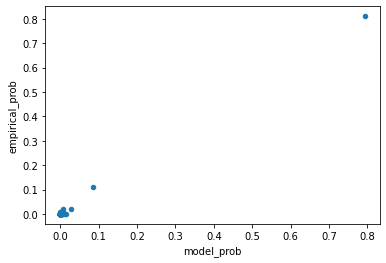

In [24]:
# Condition on the label and plot how well-calibrated the probabilities are.
label = 15
calibration_plot(base_results[base_results["label"] == label])

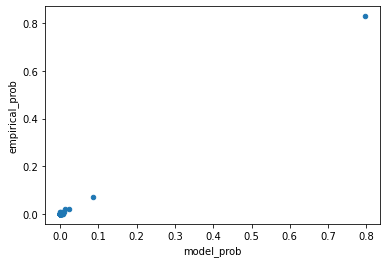

In [25]:
# Same thing as above, but conditioning on model result
calibration_plot(base_results[base_results["top1"] == label])

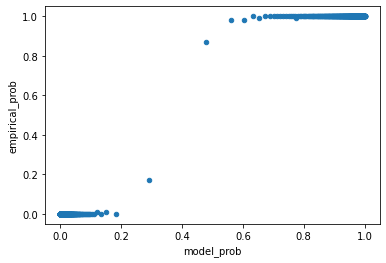

In [26]:
# Check calibration on the training set.
calibration_plot(base_train_results)

In [27]:
# Generate data for the train set too
orig_train_results = add_top_k_cols(train[["id", "probs", "label"]])
base_train_results = make_results(train, base_model)

In [28]:
# Repeat with reduced-capacity models
model_1024 = train_reduced_model(train, 1024)
model_32 = train_reduced_model(train, 32)
model_16 = train_reduced_model(train, 16)

results_16 = make_results(test, model_16)
results_32 = make_results(test, model_32)
results_1024 = make_results(test, model_1024)

train_results_16 = make_results(train, model_16)
train_results_32 = make_results(train, model_32)
train_results_1024 = make_results(train, model_1024)

In [29]:
# Compute aggregate top-1 accuracy
def top_1_acc(df):
    return (df["top1"] == df["label"]).sum() / len(df.index)


def top_5_acc(df):
    return df["top5_match"].sum() / len(df.index) 


print(f"------TEST FOLD-------| top-1  | top-5  |")
print(f"        Original model: {top_1_acc(orig_results):1.4f}   {top_5_acc(orig_results):1.4f}")
print(f"Baseline sklearn model: {top_1_acc(base_results):1.4f}   {top_5_acc(base_results):1.4f}")
print(f"   1024-dim projection: {top_1_acc(results_1024):1.4f}   {top_5_acc(results_1024):1.4f}")
print(f"     32-dim projection: {top_1_acc(results_32):1.4f}   {top_5_acc(results_32):1.4f}")
print(f"     16-dim projection: {top_1_acc(results_16):1.4f}   {top_5_acc(results_16):1.4f}")


print("\n------TRAIN FOLD------")
print(f"        Original model: {top_1_acc(orig_train_results):1.4f}   {top_5_acc(orig_train_results):1.4f}")
print(f"Baseline sklearn model: {top_1_acc(base_train_results):1.4f}   {top_5_acc(base_train_results):1.4f}")
print(f"   1024-dim projection: {top_1_acc(train_results_1024):1.4f}   {top_5_acc(train_results_1024):1.4f}")
print(f"     32-dim projection: {top_1_acc(train_results_32):1.4f}   {top_5_acc(train_results_32):1.4f}")
print(f"     16-dim projection: {top_1_acc(train_results_16):1.4f}   {top_5_acc(train_results_16):1.4f}")

------TEST FOLD-------| top-1  | top-5  |
        Original model: 0.7629   0.9389
Baseline sklearn model: 0.7602   0.9369
   1024-dim projection: 0.7606   0.9362
     32-dim projection: 0.7213   0.8919
     16-dim projection: 0.6434   0.8326

------TRAIN FOLD------
        Original model: 0.9997   1.0000
Baseline sklearn model: 0.9997   1.0000
   1024-dim projection: 0.9997   1.0000
     32-dim projection: 0.9914   0.9998
     16-dim projection: 0.9226   0.9912


In [30]:
# Results look ok so far. Define a more exhaustive set of parameters
# for reduced-capacity models.
N_COMPONENTS = [256, 64, 32, 16]
SEEDS = [1, 2, 3, 4]

params = [(comp, seed) for comp in N_COMPONENTS for seed in SEEDS]
print(params)

[(256, 1), (256, 2), (256, 3), (256, 4), (64, 1), (64, 2), (64, 3), (64, 4), (32, 1), (32, 2), (32, 3), (32, 4), (16, 1), (16, 2), (16, 3), (16, 4)]


In [31]:
num_features = test["features"].iloc[0].to_numpy().shape[0]
models = { (num_features, 0): base_model }

for p in params:
    models[p] = train_reduced_model(train, p[0], p[1])

### Analyze ensemble outputs

In [32]:
# Run inference over the test set for each model in the ensemble.
res_by_model = {
    k: make_results(test, m)
    for k, m in models.items()
}

res_by_model[(32, 1)]

,id,probs,label,label_prob,top1,top1_prob,top5,top5_match
0,0,"[ 0.020006992337526047, 1.3235907398068398e-0...",49,0.009435,60,0.138853,"[60, 41, 15, 76, 69]",False
1,1,"[ 9.397591027067654e-07, 4.7946783592905506e-0...",33,0.912383,33,0.912383,"[33, 84, 88, 96, 31]",True
2,2,"[ 0.0003158327671417566, 1.869252883208701e-0...",72,0.025437,55,0.733003,"[55, 19, 4, 72, 44]",True
3,3,"[0.00027914329606278007, 0.000865386788590746...",51,0.893142,51,0.893142,"[51, 18, 37, 93, 6]",True
4,4,"[ 8.217354574308542e-05, 0.0002699144762239442...",71,0.932595,71,0.932595,"[71, 23, 60, 99, 69]",True
...,...,...,...,...,...,...,...,...
9995,9995,"[ 0.14713142454194764, 4.449513187062798e-0...",83,0.617446,83,0.617446,"[83, 0, 57, 92, 70]",True
9996,9996,"[0.00016103459697946386, 0.0003400398216689738...",14,0.279681,14,0.279681,"[14, 63, 18, 6, 32]",True
9997,9997,"[1.6668486850872452e-06, 4.741367068223157e-0...",51,0.999130,51,0.999130,"[51, 93, 37, 31, 90]",True
9998,9998,"[5.4649052201255666e-05, 4.909662087940611e-0...",42,0.920949,42,0.920949,"[42, 21, 43, 88, 55]",True


In [33]:
# Compute accuracy statistics for the members of the ensemble
records = []
for t, m in models.items():
    num_dims, seed = t

    results = res_by_model[t]
    results_train = make_results(train, m)
    
    records.append({
        "num_dims": num_dims,
        "seed": seed,
        "top_1": top_1_acc(results),
        "top_1_train": top_1_acc(results_train),
        "top_5": top_5_acc(results),
        "top_5_train": top_5_acc(results_train)
    })

accuracies = pd.DataFrame.from_records(records)
accuracies

,num_dims,seed,top_1,top_1_train,top_5,top_5_train
0,1792,0,0.7602,0.99974,0.9369,1.00000
1,256,1,0.7597,0.99956,0.9324,1.00000
2,256,2,0.7583,0.99956,0.9336,1.00000
3,256,3,0.7564,0.99976,0.9337,1.00000
4,256,4,0.7574,0.99966,0.9335,1.00000
5,64,1,0.7466,0.99868,0.9171,1.00000
6,64,2,0.7461,0.99886,0.9202,1.00000
7,64,3,0.7435,0.99860,0.9149,1.00000
8,64,4,0.7435,0.99852,0.9195,1.00000
9,32,1,0.7252,0.99130,0.8947,0.99982


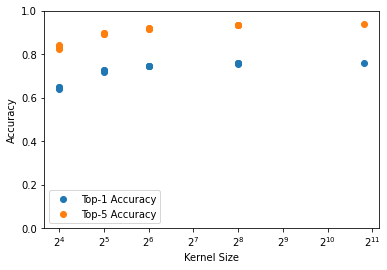

In [34]:
# Plot accuracy stats for the models in the ensemble
plt.scatter(accuracies["num_dims"], accuracies["top_1"], label="Top-1 Accuracy")
plt.scatter(accuracies["num_dims"], accuracies["top_5"], label="Top-5 Accuracy")
plt.xscale("log", base=2)
plt.ylim((0, 1.0))

plt.ylabel("Accuracy")
plt.xlabel("Kernel Size")
plt.legend()
plt.show()

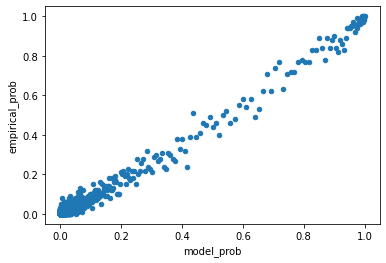

In [35]:
# Check calibration of the low-dimensional models
calibration_plot(res_by_model[(16, 1)])

In [36]:
res_by_model.keys()

dict_keys([(1792, 0), (256, 1), (256, 2), (256, 3), (256, 4), (64, 1), (64, 2), (64, 3), (64, 4), (32, 1), (32, 2), (32, 3), (32, 4), (16, 1), (16, 2), (16, 3), (16, 4)])

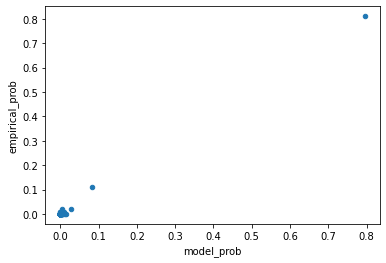

In [37]:
# Check calibration of high-dimensional model when conditioned on a single
# actual class
result = res_by_model[(256, 1)]
calibration_plot(result[result["label"] == 15])

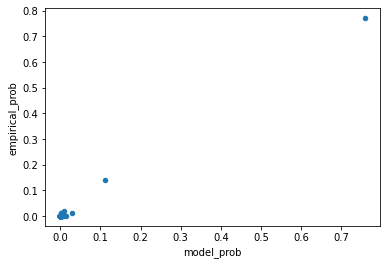

In [38]:
calibration_plot(result[result["top1"] == 7])

In [39]:
# Generate string model names and use them to index results
# First as one DataFrame per model
res_by_model_name = {}
for k, v in res_by_model.items():
    model_name = f"{k[0]}_{k[1]}"
    model_results = v.copy()
    model_results.insert(0, "model_name", model_name)
    res_by_model_name[model_name] = model_results

# And also as a single big DataFrame with a leading column
all_results = pd.concat(res_by_model_name.values())

res_by_model_name["1792_0"].head(3)

,model_name,id,probs,label,label_prob,top1,top1_prob,top5,top5_match
0,1792_0,0,"[ 0.005854557127795873, 0.001044076868371778...",49,0.012577,90,0.150746,"[90, 69, 60, 68, 55]",False
1,1792_0,1,"[ 9.559308234828802e-05, 0.000254882639461478...",33,0.836550,33,0.836550,"[33, 84, 88, 40, 81]",True
2,1792_0,2,"[ 8.761981268529843e-05, 1.5968990653538752e-0...",72,0.036595,55,0.769059,"[55, 4, 72, 3, 27]",True


In [40]:
all_results.tail(3)

,model_name,id,probs,label,label_prob,top1,top1_prob,top5,top5_match
9997,16_4,9997,"[1.1193675189385943e-08, 2.7775074184064864e-0...",51,0.974108,51,0.974108,"[51, 65, 44, 93, 38]",True
9998,16_4,9998,"[ 0.0009778664515245356, 0.0270621502901644...",42,0.422218,42,0.422218,"[42, 30, 72, 31, 9]",True
9999,16_4,9999,"[2.9640872417138163e-07, 1.5544119958699287e-0...",70,0.942056,70,0.942056,"[70, 92, 26, 54, 99]",True


## Strawman algorithm

Use a fixed threshold on calibrated self-confidence to choose which examples to flag.
We adjust the threshold so as to flag a specific target number of examples.

In [41]:
num_to_flag = 10
strawman_flagged = base_results.nsmallest(num_to_flag, "label_prob")
strawman_flagged

,id,probs,label,label_prob,top1,top1_prob,top5,top5_match
2827,2827,"[ 8.345656068512821e-07, 5.071488410662216e-0...",27,0.000003,42,0.999555,"[42, 63, 97, 14, 21]",False
5278,5278,"[3.5692894026954137e-07, 3.685018938115039e-0...",81,0.000035,13,0.999556,"[13, 58, 9, 81, 90]",True
7762,7762,"[ 8.834270968352225e-05, 0.000133928935708880...",28,0.000036,9,0.965235,"[ 9, 18, 69, 16, 83]",False
5282,5282,"[ 0.0017761725553559408, 5.6373196617327885e-0...",10,0.000041,53,0.985309,"[53, 0, 57, 99, 61]",False
3854,3854,"[ 4.016521383131065e-07, 1.8385797802017932e-0...",65,0.000056,38,0.999226,"[38, 97, 19, 15, 65]",True
6513,6513,"[3.4606966887233296e-05, 1.00186477729283e-0...",93,0.000061,44,0.918542,"[44, 99, 18, 27, 55]",False
4649,4649,"[ 7.010218796177023e-05, 0.0001134710394969118...",64,0.000084,55,0.962537,"[55, 72, 29, 3, 34]",False
2192,2192,"[ 3.935447393159288e-06, 5.210264672152448e-0...",54,0.000086,14,0.975118,"[14, 18, 6, 22, 35]",False
7399,7399,"[ 8.774374834295022e-05, 1.4242555317047034e-0...",80,0.000092,55,0.547289,"[55, 72, 4, 30, 95]",False
6082,6082,"[2.0858084274108975e-05, 4.242581252826797e-0...",5,0.000098,25,0.975534,"[25, 10, 2, 24, 11]",False


Image 5282:


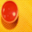

Corpus label: 10 ==> bowl
Top 5 results: [53  0 57 99 61] ==> ['orange', 'apple', 'pear', 'worm', 'plate']
Image 2827:


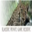

Corpus label: 27 ==> crocodile
Top 5 results: [42 63 97 14 21] ==> ['leopard', 'porcupine', 'wolf', 'butterfly', 'chimpanzee']
Image 7399:


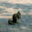

Corpus label: 80 ==> squirrel
Top 5 results: [55 72  4 30 95] ==> ['otter', 'seal', 'beaver', 'dolphin', 'whale']
Image 5278:


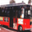

Corpus label: 81 ==> streetcar
Top 5 results: [13 58  9 81 90] ==> ['bus', 'pickup_truck', 'bottle', 'streetcar', 'train']
Image 6513:


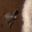

Corpus label: 93 ==> turtle
Top 5 results: [44 99 18 27 55] ==> ['lizard', 'worm', 'caterpillar', 'crocodile', 'otter']
Image 3854:


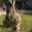

Corpus label: 65 ==> rabbit
Top 5 results: [38 97 19 15 65] ==> ['kangaroo', 'wolf', 'cattle', 'camel', 'rabbit']
Image 7762:


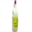

Corpus label: 28 ==> cup
Top 5 results: [ 9 18 69 16 83] ==> ['bottle', 'caterpillar', 'rocket', 'can', 'sweet_pepper']
Image 2192:


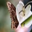

Corpus label: 54 ==> orchid
Top 5 results: [14 18  6 22 35] ==> ['butterfly', 'caterpillar', 'bee', 'clock', 'girl']
Image 4649:


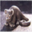

Corpus label: 64 ==> possum
Top 5 results: [55 72 29  3 34] ==> ['otter', 'seal', 'dinosaur', 'bear', 'fox']
Image 6082:


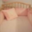

Corpus label: 5 ==> bed
Top 5 results: [25 10  2 24 11] ==> ['couch', 'bowl', 'baby', 'cockroach', 'boy']


In [42]:
# Pick 10 random examples
for idx in strawman_flagged.sample(10).index:
    result_report(strawman_flagged, cifar100_test, idx)

In [43]:
# Alternate version: Look for high confidence in wrong answers
# confidence_threshold = 0.8

# strawman_flagged = base_results[
#     (base_results["label"] != base_results["top1"])
#     & (base_results["top1_prob"] > confidence_threshold)]
# strawman_flagged

## Ensemble-based algorithms

### Baseline: Ensemble method from our CoNLL-2020 paper

We count how many models in the ensemble produced each distinct top-1 result.
Then we look for cases where many models produced a label that is not in the 
corpus or where many models did not produce the corpus label for a given 
example.

We choose thresholds for the value of "many models" so as to flag about 50 
examples.

In [44]:
in_gold, not_in_gold = tp.cleaning.flag_suspicious_labels(
    predicted_features=res_by_model_name,
    corpus_label_col="label",
    predicted_label_col="top1",
    align_over_cols=["id"],
    keep_cols=[])

# Convert class labels to strings.
class_names = pd.DataFrame({
    "class": range(len(cifar100_train.classes)),
    "class_name": cifar100_train.classes
})
in_gold = in_gold.merge(class_names)
not_in_gold = not_in_gold.merge(class_names)

In [45]:
# in_gold: Corpus labels, annotated with how many models found that label
in_gold.head()

,id,class,in_gold,count,models,class_name
0,9994,50,True,0,[GOLD],mouse
1,9152,50,True,0,[GOLD],mouse
2,9037,50,True,0,[GOLD],mouse
3,7326,50,True,0,[GOLD],mouse
4,7150,50,True,0,[GOLD],mouse


In [46]:
# not_in_gold: Labels found by models that are not in the corpus labels
not_in_gold.head()

,id,class,in_gold,count,models,class_name
0,9971,58,False,17,"[1792_0, 256_1, 256_2, 256_3, 256_4, 64_1, 64_...",pickup_truck
1,7320,58,False,17,"[1792_0, 256_1, 256_2, 256_3, 256_4, 64_1, 64_...",pickup_truck
2,619,58,False,17,"[1792_0, 256_1, 256_2, 256_3, 256_4, 64_1, 64_...",pickup_truck
3,4426,58,False,16,"[1792_0, 256_1, 256_2, 256_3, 256_4, 64_1, 64_...",pickup_truck
4,7146,58,False,15,"[1792_0, 256_1, 256_2, 256_3, 256_4, 64_1, 64_...",pickup_truck


In [47]:
# Thresholds
in_gold_threshold = 1
not_in_gold_threshold = 16

in_gold_rows = in_gold[in_gold["count"] < in_gold_threshold]
not_in_gold_rows = not_in_gold[not_in_gold["count"] > not_in_gold_threshold]
(len(in_gold_rows.index), len(not_in_gold_rows.index))

(1322, 294)

There are 1322 examples for which none of the models found the corpus label, so we can't pick a threshold that will give us our target of 50 flagged examples.

### Improved Ensemble Methods

Rather than looking purely at top-1 results, we aggregate the detailed class probabilities that the models in the ensemble produce for each example. This approach allows us to set a more fine-grained threshold when choosing which examples to flag.

We start by computing a DataFrame of probabilities for all combinations of model and example.

In [48]:
all_ensemble_results = pd.concat(res_by_model_name.values())[["model_name", "id", "probs", "label"]]
all_ensemble_results

,model_name,id,probs,label
0,1792_0,0,"[ 0.005854557127795873, 0.001044076868371778...",49
1,1792_0,1,"[ 9.559308234828802e-05, 0.000254882639461478...",33
2,1792_0,2,"[ 8.761981268529843e-05, 1.5968990653538752e-0...",72
3,1792_0,3,"[ 0.0003684075279662523, 0.000954082237377838...",51
4,1792_0,4,"[0.00011528890187400213, 1.0516887165878677e-0...",71
...,...,...,...,...
9995,16_4,9995,"[ 0.032673408635511804, 3.339811009622974e-0...",83
9996,16_4,9996,"[6.0110438255074184e-05, 0.000710782417777520...",14
9997,16_4,9997,"[1.1193675189385943e-08, 2.7775074184064864e-0...",51
9998,16_4,9998,"[ 0.0009778664515245356, 0.0270621502901644...",42


Next we aggregate together the probabilities for each example. There are several aggregates we can use. We'll compute them all in a single pass.

In [49]:
# Some of these aggregates can be computed by Pandas groupby().agg(),
# but others cannot. So we iterate over the groups and do everything
# in a consistent fashion.
records = []
for id_, rows in all_ensemble_results.groupby("id"):
    probs = rows["probs"].to_numpy()
    label = rows["label"].iloc[0]
    records.append({
        "id": id_,
        "label": label,
        "mean": np.mean(probs, axis=0),
        "max": np.max(probs, axis=0),
        "min": np.min(probs, axis=0),
        # Harmonic mean
        "hmean": scipy.stats.mstats.hmean(probs, axis=0),
        # Geometric mean
        "gmean": scipy.stats.mstats.gmean(probs, axis=0),
    })

agg_probs = pd.DataFrame.from_records(records)
agg_probs

,id,label,mean,max,min,hmean,gmean
0,0,49,"[0.006078788630875156, 0.0033655518524998668, ...","[0.02093544147253415, 0.024465179825631043, 0....","[6.414496272645663e-05, 1.6837027177841194e-07...","[0.0007547830394816586, 1.6731659988641337e-06...","[0.0031818019255242637, 0.0001637921617610823,..."
1,1,33,"[5.49549432244636e-05, 0.00010342830771785922,...","[0.000180963596732137, 0.00044550853398213195,...","[3.597347678787815e-09, 1.8000862012657325e-07...","[6.078176822182054e-08, 1.6499347140318228e-06...","[1.8567691919982884e-05, 3.49637018547335e-05,..."
2,2,72,"[0.00012546697944818534, 6.211834743788112e-05...","[0.0006677157830083624, 0.0008486283902404709,...","[3.335955307114795e-08, 2.8421155028665127e-08...","[5.28642863678113e-07, 4.487922358262514e-07, ...","[2.7957940224290562e-05, 7.923807407088013e-06..."
3,3,51,"[0.00031484518710906767, 0.0006306046859906477...","[0.001321113562575155, 0.0020763797786939753, ...","[1.4384239931937755e-06, 1.3996542212480226e-0...","[1.0501281993133871e-05, 0.0001053322804739558...","[0.000104523678626729, 0.0003466919234424472, ..."
4,4,71,"[0.00014257256774090452, 3.45362374188662e-05,...","[0.000344658753487889, 0.00026991447622394424,...","[5.319895129399326e-06, 2.818946587663537e-10,...","[4.2699553758781904e-05, 4.681810411799139e-09...","[9.298708381853386e-05, 4.29282489085698e-06, ..."
...,...,...,...,...,...,...,...
9995,9995,83,"[0.12581699736375762, 0.00018599111224821147, ...","[0.4164225460357865, 0.000382438597038608, 0.0...","[0.031366415343826025, 5.9079549053359e-06, 2....","[0.08625745398493564, 4.8643583485056334e-05, ...","[0.1048887026775574, 0.00012057236389914004, 0..."
9996,9996,14,"[0.00020829404757629944, 0.0012157728001633648...","[0.0018254767913682116, 0.01162753416375392, 0...","[2.443442833398621e-07, 4.957881275983026e-08,...","[3.698668269454702e-06, 8.382132403802123e-07,...","[6.444358752371283e-05, 0.0002639824302575096,..."
9997,9997,51,"[3.3598604353837935e-06, 5.676749362831422e-06...","[2.277589598438002e-05, 2.7775074184064864e-05...","[5.719531465300544e-10, 2.2081595350015205e-08...","[7.68068386285974e-09, 2.1631123910768984e-07,...","[4.751315260768693e-07, 2.1133096737967632e-06..."
9998,9998,42,"[0.0003182718660968549, 0.0017201826472122166,...","[0.0009778664515245356, 0.02706215029016447, 0...","[5.57861240610031e-07, 7.966975174154501e-07, ...","[4.255170614406911e-06, 6.456836238636943e-06,...","[9.288007594297178e-05, 6.62188789927811e-05, ..."


First we'll look for cases where the aggregate confidence in the corpus label is below a threshold. We choose thresholds so as to flag exactly the target number of examples.

In [50]:
agg_names = ("mean", "max", "min", "hmean", "gmean")

# Pull out the aggregated probability of the corpus label for each example
agg_label_probs = agg_probs.copy()
for name in agg_names:
    agg_label_probs[name] = [e[l] for e, l in zip(agg_probs[name], agg_probs["label"])]
    
# Pick k lowest aggregate scores for the corpus labels
flagged_ids = {
    name: list(agg_label_probs.nsmallest(num_to_flag, name)["id"])
    for name in agg_names
}

{ name: len(flagged_ids[name]) for name in agg_names }

{'mean': 10, 'max': 10, 'min': 10, 'hmean': 10, 'gmean': 10}

Show 10 random examples of what we get with each aggregate.

Image 7657:


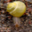

Corpus label: 77 ==> snail
Top 5 results: [51 65 40 59 78] ==> ['mushroom', 'rabbit', 'lamp', 'pine_tree', 'snake']
Image 5282:


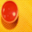

Corpus label: 10 ==> bowl
Top 5 results: [53 28 16 40 12] ==> ['orange', 'cup', 'can', 'lamp', 'bridge']
Image 6082:


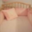

Corpus label: 5 ==> bed
Top 5 results: [25 24 99 11  2] ==> ['couch', 'cockroach', 'worm', 'boy', 'baby']
Image 7173:


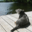

Corpus label: 64 ==> possum
Top 5 results: [72 55 13 34  5] ==> ['seal', 'otter', 'bus', 'fox', 'bed']
Image 1768:


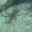

Corpus label: 26 ==> crab
Top 5 results: [45 67 40 49  7] ==> ['lobster', 'ray', 'lamp', 'mountain', 'beetle']
Image 2827:


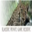

Corpus label: 27 ==> crocodile
Top 5 results: [42 18 31 29 85] ==> ['leopard', 'caterpillar', 'elephant', 'dinosaur', 'tank']
Image 5278:


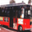

Corpus label: 81 ==> streetcar
Top 5 results: [13 72 21 55 95] ==> ['bus', 'seal', 'chimpanzee', 'otter', 'whale']
Image 3897:


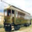

Corpus label: 90 ==> train
Top 5 results: [81 12 16 66 13] ==> ['streetcar', 'bridge', 'can', 'raccoon', 'bus']
Image 7399:


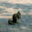

Corpus label: 80 ==> squirrel
Top 5 results: [55  3  4 19 72] ==> ['otter', 'bear', 'beaver', 'cattle', 'seal']
Image 7762:


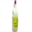

Corpus label: 28 ==> cup
Top 5 results: [ 9 19 42 40 31] ==> ['bottle', 'cattle', 'leopard', 'lamp', 'elephant']


In [51]:
# Examples for the "mean" aggregate.
# Note that we're using the main model's results to generate the "top 5 results" part of the report
for idx in random.sample(flagged_ids["mean"], 10):
    result_report(model_results, cifar100_test, idx)

Image 7173:


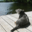

Corpus label: 64 ==> possum
Top 5 results: [72 55 13 34  5] ==> ['seal', 'otter', 'bus', 'fox', 'bed']
Image 7657:


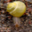

Corpus label: 77 ==> snail
Top 5 results: [51 65 40 59 78] ==> ['mushroom', 'rabbit', 'lamp', 'pine_tree', 'snake']
Image 7002:


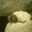

Corpus label: 64 ==> possum
Top 5 results: [72 65 36 35  2] ==> ['seal', 'rabbit', 'hamster', 'girl', 'baby']
Image 5278:


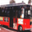

Corpus label: 81 ==> streetcar
Top 5 results: [13 72 21 55 95] ==> ['bus', 'seal', 'chimpanzee', 'otter', 'whale']
Image 1768:


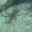

Corpus label: 26 ==> crab
Top 5 results: [45 67 40 49  7] ==> ['lobster', 'ray', 'lamp', 'mountain', 'beetle']
Image 7399:


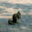

Corpus label: 80 ==> squirrel
Top 5 results: [55  3  4 19 72] ==> ['otter', 'bear', 'beaver', 'cattle', 'seal']
Image 3897:


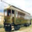

Corpus label: 90 ==> train
Top 5 results: [81 12 16 66 13] ==> ['streetcar', 'bridge', 'can', 'raccoon', 'bus']
Image 2827:


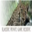

Corpus label: 27 ==> crocodile
Top 5 results: [42 18 31 29 85] ==> ['leopard', 'caterpillar', 'elephant', 'dinosaur', 'tank']
Image 7762:


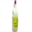

Corpus label: 28 ==> cup
Top 5 results: [ 9 19 42 40 31] ==> ['bottle', 'cattle', 'leopard', 'lamp', 'elephant']
Image 6082:


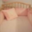

Corpus label: 5 ==> bed
Top 5 results: [25 24 99 11  2] ==> ['couch', 'cockroach', 'worm', 'boy', 'baby']


In [52]:
# Examples for the "max" aggregate.
for idx in random.sample(flagged_ids["max"], 10):
    result_report(model_results, cifar100_test, idx)

Image 6909:


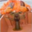

Corpus label: 45 ==> lobster
Top 5 results: [19 43 15 88  3] ==> ['cattle', 'lion', 'camel', 'tiger', 'bear']
Image 886:


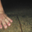

Corpus label: 99 ==> worm
Top 5 results: [45 24 40 67 94] ==> ['lobster', 'cockroach', 'lamp', 'ray', 'wardrobe']
Image 2827:


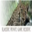

Corpus label: 27 ==> crocodile
Top 5 results: [42 18 31 29 85] ==> ['leopard', 'caterpillar', 'elephant', 'dinosaur', 'tank']
Image 2192:


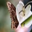

Corpus label: 54 ==> orchid
Top 5 results: [14 79 26 44 18] ==> ['butterfly', 'spider', 'crab', 'lizard', 'caterpillar']
Image 8394:


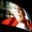

Corpus label: 87 ==> television
Top 5 results: [35  2 11 93 46] ==> ['girl', 'baby', 'boy', 'turtle', 'man']
Image 4300:


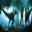

Corpus label: 29 ==> dinosaur
Top 5 results: [ 9  8 42 30 12] ==> ['bottle', 'bicycle', 'leopard', 'dolphin', 'bridge']
Image 9976:


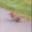

Corpus label: 65 ==> rabbit
Top 5 results: [55 50 74 77 80] ==> ['otter', 'mouse', 'shrew', 'snail', 'squirrel']
Image 1768:


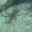

Corpus label: 26 ==> crab
Top 5 results: [45 67 40 49  7] ==> ['lobster', 'ray', 'lamp', 'mountain', 'beetle']
Image 2620:


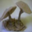

Corpus label: 51 ==> mushroom
Top 5 results: [27 44 78 18 29] ==> ['crocodile', 'lizard', 'snake', 'caterpillar', 'dinosaur']
Image 416:


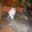

Corpus label: 27 ==> crocodile
Top 5 results: [25 32  5 41 85] ==> ['couch', 'flatfish', 'bed', 'lawn_mower', 'tank']


In [53]:
# Examples for the "min" aggregate.
for idx in random.sample(flagged_ids["min"], 10):
    result_report(model_results, cifar100_test, idx)

Image 4300:


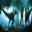

Corpus label: 29 ==> dinosaur
Top 5 results: [ 9  8 42 30 12] ==> ['bottle', 'bicycle', 'leopard', 'dolphin', 'bridge']
Image 416:


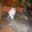

Corpus label: 27 ==> crocodile
Top 5 results: [25 32  5 41 85] ==> ['couch', 'flatfish', 'bed', 'lawn_mower', 'tank']
Image 2192:


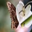

Corpus label: 54 ==> orchid
Top 5 results: [14 79 26 44 18] ==> ['butterfly', 'spider', 'crab', 'lizard', 'caterpillar']
Image 886:


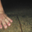

Corpus label: 99 ==> worm
Top 5 results: [45 24 40 67 94] ==> ['lobster', 'cockroach', 'lamp', 'ray', 'wardrobe']
Image 6909:


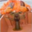

Corpus label: 45 ==> lobster
Top 5 results: [19 43 15 88  3] ==> ['cattle', 'lion', 'camel', 'tiger', 'bear']
Image 2620:


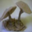

Corpus label: 51 ==> mushroom
Top 5 results: [27 44 78 18 29] ==> ['crocodile', 'lizard', 'snake', 'caterpillar', 'dinosaur']
Image 2827:


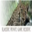

Corpus label: 27 ==> crocodile
Top 5 results: [42 18 31 29 85] ==> ['leopard', 'caterpillar', 'elephant', 'dinosaur', 'tank']
Image 9976:


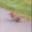

Corpus label: 65 ==> rabbit
Top 5 results: [55 50 74 77 80] ==> ['otter', 'mouse', 'shrew', 'snail', 'squirrel']
Image 1768:


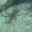

Corpus label: 26 ==> crab
Top 5 results: [45 67 40 49  7] ==> ['lobster', 'ray', 'lamp', 'mountain', 'beetle']
Image 8394:


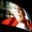

Corpus label: 87 ==> television
Top 5 results: [35  2 11 93 46] ==> ['girl', 'baby', 'boy', 'turtle', 'man']


In [54]:
# Examples for the "hmean" aggregate.
for idx in random.sample(flagged_ids["hmean"], 10):
    result_report(model_results, cifar100_test, idx)

Image 4649:


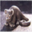

Corpus label: 64 ==> possum
Top 5 results: [55 72 38 13  3] ==> ['otter', 'seal', 'kangaroo', 'bus', 'bear']
Image 2827:


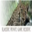

Corpus label: 27 ==> crocodile
Top 5 results: [42 18 31 29 85] ==> ['leopard', 'caterpillar', 'elephant', 'dinosaur', 'tank']
Image 5282:


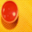

Corpus label: 10 ==> bowl
Top 5 results: [53 28 16 40 12] ==> ['orange', 'cup', 'can', 'lamp', 'bridge']
Image 1768:


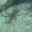

Corpus label: 26 ==> crab
Top 5 results: [45 67 40 49  7] ==> ['lobster', 'ray', 'lamp', 'mountain', 'beetle']
Image 9093:


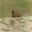

Corpus label: 15 ==> camel
Top 5 results: [27 74 55 44 50] ==> ['crocodile', 'shrew', 'otter', 'lizard', 'mouse']
Image 7173:


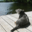

Corpus label: 64 ==> possum
Top 5 results: [72 55 13 34  5] ==> ['seal', 'otter', 'bus', 'fox', 'bed']
Image 6082:


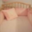

Corpus label: 5 ==> bed
Top 5 results: [25 24 99 11  2] ==> ['couch', 'cockroach', 'worm', 'boy', 'baby']
Image 7657:


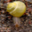

Corpus label: 77 ==> snail
Top 5 results: [51 65 40 59 78] ==> ['mushroom', 'rabbit', 'lamp', 'pine_tree', 'snake']
Image 5278:


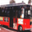

Corpus label: 81 ==> streetcar
Top 5 results: [13 72 21 55 95] ==> ['bus', 'seal', 'chimpanzee', 'otter', 'whale']
Image 2192:


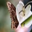

Corpus label: 54 ==> orchid
Top 5 results: [14 79 26 44 18] ==> ['butterfly', 'spider', 'crab', 'lizard', 'caterpillar']


In [55]:
# Examples for the "gmean" aggregate.
for idx in random.sample(flagged_ids["gmean"], 10):
    result_report(model_results, cifar100_test, idx)

Next we'll look for cases where the aggregate confidence in a label other than the corpus label is *above* a threshold.

In [56]:
# TODO

### Unused ensemble code

In [57]:
# Old code for alternate version of ensemble algorithm where we sum top-1
# probabilities instead of just looking at the top-1 prediction of each model.

# # First pull out the labels that are in the gold standard labels.
# gold_df = test[["id", "label"]].copy()

# # Add some leading columns to match the schema of the per-model DataFrames we will
# # be aggregating together with this one.
# gold_df["weighted_count"] = 0
# gold_df["top1"] = gold_df["label"]

# gold_df["in_gold"] = True
# gold_df["models"] = "GOLD"


# to_concat = [gold_df]

# # Generate a DataFrame of top-1 results, weighted by probability, for each of the 
# # models in the ensemble, and concatenate them all together.
# for model_name, model_results in res_by_model_name.items():
#     df = model_results[["id", "label", "top1"]].copy()

#     # Use the value of the highest-probability class as the weight.
#     df["weighted_count"] = np.stack(model_results["probs"].to_numpy()).max(axis=1)

#     # Add leading columns for aggregation
#     df["in_gold"] = False
#     df["models"] = model_name
#     to_concat.append(df)

# all_feats = pd.concat(to_concat)
# all_feats

# # Aggregate the DataFrame from the previous cell to produce one row
# # per [id, top1] pair
# res = (
#     all_feats
#     .groupby(["id", "top1"])
#     .agg({
#         "in_gold": "any",
#         "weighted_count": "sum",
#         "models": lambda x: list(x)
#     })
#     .reset_index()  # Make "id" and "label" back into a normal series
# )
# res

In [58]:
# Old code for an alternate version of the ensemble algorithm where we take the 
# sum of probabilities for all models for each class.

# # Stuff the probabilities from all the models into a single tensor of
# # shape <num models, num examples, num classes>
# arrs = np.stack([res["probs"].to_numpy() for res in res_by_model_name.values()])

# # Sum up along the "model" dimension to get a tensor of size
# # <num examples, num classes>. Each entry contains the total of
# # the probability values for that example being in that class
# # across all the models
# sum_arr = arrs.sum(axis=0)

# first_model_output = next(iter(res_by_model_name.values()))

# # Find the top probability in each row of sum_arr and mark that as
# # the top-1 choice of the ensemble.
# combined_probs = pd.DataFrame({
#     "id": first_model_output["id"].copy(),
#     "top1": np.argmax(sum_arr, axis=1),
#     "probs": tp.TensorArray(sum_arr),
#     "weighted_count": np.max(sum_arr, axis=1)})
# combined_probs

# # Use gold_df from before
# combined_df = gold_df[["id", "top1", "in_gold"]].copy().merge(combined_probs, how='outer')

# # combined_df['in_gold'] = combined_df['predicted_class'].eq(combined_df.corpus_tag)
# # combined_df[~combined_df.in_gold].sort_values(['weighted_sum','fold','doc_num'],ascending = [False,True,True])

# combined_df

## Algorithms from the Confident Learning paper

Create a confident joint using methodology from the Confident Learning (CL) paper,
then, use three different error flagging approaches to flag suspicious entities

2. **Confident Joint:** use off diagonals from the confusion matrix 
3. **Prune by Class:** use n*(row_sum(Q) ) and choose the n lowest self_confidence values from each labeled class
4. **Prune by Noise Rate:** choose n*Q<sub>i,j</sub> for each bin: (y&#771; =i, y<super> *</super>=j)

### Input data

All information required by the CL algorithms is in our DataFrames of model results.
Here we use the results of the model that was trained by running logistic regression
over the entire set of features that the original pretrained model produced.

We make a copy because we're going to add some columns.

In [59]:
model_results = res_by_model[(num_features, 0)].copy()
model_results

,id,probs,label,label_prob,top1,top1_prob,top5,top5_match
0,0,"[ 0.005854557127795873, 0.001044076868371778...",49,0.012577,90,0.150746,"[90, 69, 60, 68, 55]",False
1,1,"[ 9.559308234828802e-05, 0.000254882639461478...",33,0.836550,33,0.836550,"[33, 84, 88, 40, 81]",True
2,2,"[ 8.761981268529843e-05, 1.5968990653538752e-0...",72,0.036595,55,0.769059,"[55, 4, 72, 3, 27]",True
3,3,"[ 0.0003684075279662523, 0.000954082237377838...",51,0.916458,51,0.916458,"[51, 91, 37, 73, 77]",True
4,4,"[0.00011528890187400213, 1.0516887165878677e-0...",71,0.973617,71,0.973617,"[71, 23, 60, 82, 5]",True
...,...,...,...,...,...,...,...,...
9995,9995,"[ 0.1327502529918377, 0.0002147192453419326...",83,0.601070,83,0.601070,"[83, 0, 57, 92, 53]",True
9996,9996,"[ 0.0001805923354565663, 0.001021981597497340...",14,0.375980,14,0.375980,"[14, 63, 93, 74, 65]",True
9997,9997,"[ 6.153893502234097e-06, 5.777871894127568e-0...",51,0.999391,51,0.999391,"[51, 44, 84, 75, 40]",True
9998,9998,"[ 0.0002995953766039082, 9.663399880614622e-0...",42,0.921105,42,0.921105,"[42, 43, 88, 21, 74]",True


### Preliminaries

We start by gathering together the inputs that we require for the CL algorithms. 

These inputs are:
* `corpus_labels`: Vector where element $i$ contains the "correct" integer label for 
   the $i^{\text{th}}$ element of the corpus
* `self_confidence`: Vector where element $i$ contains the model's output probability 
   for the highest-probability label for the $i^{\text{th}}$ element of the corpus
* `cl_confidence`: Vector where element $i$ contains the model's highest class probability
   for element $i$ of the corpus that is above the associated probability threshold 
   in `thresholds` (see below), or zero if none of the model's output probabilities 
   are above the thresholds.
* `cl_pred`: Vector where element $i$ contains the class ID for which the model output
   the highest probability *that is above a threshold in `thresholds`*; or the corpus 
   label if all the model's output probabilities were below their associated thresholds.
* `cl_normalized_margin`: Vector where element $i$ contains the difference between:
    * the model's output probability for the class that is the corpus label for 
      element $i$ of the corpus, and
    * element $i$ of `cl_confidence`.
* `cl_predicted_on`: Vector where element $i$ is `True` if, for element $i$ of the 
  corpus, the model  output at least one class probability that was above the 
  corresponding threshold in `thresholds`.
* `num_classes`: Number of distinct labels in the corpus
* `q_matrix`: Matrix of adjusted empirical class probabilities that the 
  Confident Learning paper refers to as $Q$. 


Along the way, we also compute some intermediate values:
* `num_examples`: Number of elements in the corpus
* `model_labels`: Vector where element $i$ contains model's predicted label for 
   the $i^{\text{th}}$ element of the corpus
* `model_probs`: 2D matrix containing the model's probability for each combination of
  class and corpus element. That is, row $i$ contains all the class probabilities 
  for the $i^{\text{th}}$ element of the corpus
* `thresholds`: Vector where element $j$ contains the model's probability for
  the $j^{\text{th}}$ class, averaged over all the corpus elements for which the
  correct class label is $j$.
* `confusion_matrix`: Confusion matrix comparing model result vs. Confident Learning
  predicted result (**not** against actual corpus label, though the two are usually
  the same)


In [60]:
# Compute all the variables described above.
corpus_labels = model_results["label"].to_numpy()
num_examples = len(corpus_labels)
num_classes = len(model_results["label"].unique())

model_probs = model_results["probs"].to_numpy()
model_labels = model_results["top1"].to_numpy()
self_confidence = model_results["top1_prob"].to_numpy()
label_confidence = model_results["label_prob"].to_numpy()

# 4-step process to compute `thresholds`
threshold_mask = np.zeros_like(model_probs)
threshold_mask[range(num_examples), corpus_labels] = 1.
thresholds = np.sum(model_probs * threshold_mask, axis=0)
thresholds = thresholds/np.sum(threshold_mask,axis=0)

preds_masked = (
    # Filter out model probabilities below the thresholds
    np.where(
        (model_probs - thresholds) >= 0, 
        model_probs, 
        0)
)
cl_predicted_on = preds_masked.any(axis=1)

cl_confidence = preds_masked.max(axis=1)
cl_pred = np.where(cl_predicted_on, preds_masked.argmax(axis=1), corpus_labels)

cl_normalized_margin = label_confidence - cl_confidence

# Add the values produced so far to the model results table.
model_results["cl_pred"] = cl_pred
model_results["cl_normalized_margin"] = cl_normalized_margin
model_results["cl_predicted_on"] = cl_predicted_on

# Compute `confusion_matrix` from the `cl_pred` values we just added
# to each row. First we generate a sparse version, then a dense version.
confusion_matrix_ijv = (
    model_results.groupby(["top1", "cl_pred"])
    .agg({"id": "count"})
    .rename(columns={"id": "count"})
    .reset_index())

confusion_matrix = (
    confusion_matrix_ijv
    .pivot(index="top1", columns="cl_pred", values="count")
    .fillna(0)
    .astype(int))

# Compute a correction factor for each class label by dividing the number
# of times that class label appeared in the CleanLab recommended class
# by the number of times that the label appeared in the top-1 model output.
# The two vectors divide to generate this correction factor also happen to
# be the sums of of the rows and sums of the "confusion matrix" we just computed.
confusion_matrix_row_sums = confusion_matrix.T.sum()
confusion_matrix_col_sums = confusion_matrix.sum()
correction_factors = confusion_matrix_row_sums / confusion_matrix_col_sums

# Multiply each row of the "confusion matrix" by the correction factor
# for the associated class.
corrected_confusion_matrix = confusion_matrix * correction_factors

# Normalize the counts of this corrected confusion matrix so that they sum
# to 1. This turns them into empirical probabilities of some sort. Confident
# Learning calls the resulting matrix "Q"
q_matrix = corrected_confusion_matrix / sum(corrected_confusion_matrix)

### CL Algorithm 1: Prune by confident joint

This algorithm finds elements that are "off-diagonal" (i.e. the model's top-1 prediction doesn't match the corpus label) and have "low normalized margin" (i.e. the model's confidence in the corpus label is much lower than the model's highest confidence for any label after some filtering).

In [61]:
cl_alg1_results = (
    model_results[
        (model_results["label"] != model_results["cl_pred"])
        & model_results["cl_predicted_on"]]
    .nsmallest(num_to_flag, "cl_normalized_margin")
)
cl_alg1_results

,id,probs,label,label_prob,top1,top1_prob,top5,top5_match,cl_pred,cl_normalized_margin,cl_predicted_on
2827,2827,"[ 8.345656068512821e-07, 5.071488410662216e-0...",27,0.000003,42,0.999555,"[42, 63, 97, 14, 21]",False,42,-0.999552,True
5278,5278,"[3.5692894026954137e-07, 3.685018938115039e-0...",81,0.000035,13,0.999556,"[13, 58, 9, 81, 90]",True,13,-0.999521,True
3854,3854,"[ 4.016521383131065e-07, 1.8385797802017932e-0...",65,0.000056,38,0.999226,"[38, 97, 19, 15, 65]",True,38,-0.999171,True
3897,3897,"[3.6330576353761353e-06, 3.3093128314896235e-0...",90,0.000223,81,0.998794,"[81, 13, 90, 37, 4]",True,81,-0.998571,True
7657,7657,"[ 6.227571202262983e-05, 3.031955015452487e-0...",77,0.000137,51,0.998027,"[51, 92, 40, 77, 57]",True,51,-0.997890,True
8951,8951,"[1.0623212131676658e-05, 1.0170336508546508e-0...",47,0.000562,52,0.998115,"[52, 47, 59, 90, 9]",True,52,-0.997553,True
8937,8937,"[ 3.208816918639135e-05, 1.1773888317706816e-0...",47,0.000430,52,0.997687,"[52, 47, 60, 74, 34]",True,52,-0.997257,True
7384,7384,"[3.3099286357899025e-05, 4.790653474253331e-0...",47,0.000223,52,0.997435,"[52, 90, 47, 3, 96]",True,52,-0.997212,True
7020,7020,"[1.0910608817704933e-05, 3.4747439862327584e-0...",26,0.000503,45,0.997528,"[45, 26, 79, 56, 44]",True,45,-0.997025,True
1214,1214,"[ 3.619543175943635e-06, 7.472056832959343e-0...",45,0.001244,26,0.998120,"[26, 45, 78, 79, 22]",True,26,-0.996876,True


Image 8937:


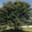

Corpus label: 47 ==> maple_tree
Top 5 results: [52 47 60 74 34] ==> ['oak_tree', 'maple_tree', 'plain', 'shrew', 'fox']
Image 1214:


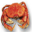

Corpus label: 45 ==> lobster
Top 5 results: [26 45 78 79 22] ==> ['crab', 'lobster', 'snake', 'spider', 'clock']
Image 5278:


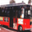

Corpus label: 81 ==> streetcar
Top 5 results: [13 58  9 81 90] ==> ['bus', 'pickup_truck', 'bottle', 'streetcar', 'train']
Image 7657:


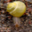

Corpus label: 77 ==> snail
Top 5 results: [51 92 40 77 57] ==> ['mushroom', 'tulip', 'lamp', 'snail', 'pear']
Image 7384:


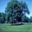

Corpus label: 47 ==> maple_tree
Top 5 results: [52 90 47  3 96] ==> ['oak_tree', 'train', 'maple_tree', 'bear', 'willow_tree']
Image 3897:


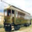

Corpus label: 90 ==> train
Top 5 results: [81 13 90 37  4] ==> ['streetcar', 'bus', 'train', 'house', 'beaver']
Image 8951:


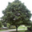

Corpus label: 47 ==> maple_tree
Top 5 results: [52 47 59 90  9] ==> ['oak_tree', 'maple_tree', 'pine_tree', 'train', 'bottle']
Image 3854:


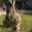

Corpus label: 65 ==> rabbit
Top 5 results: [38 97 19 15 65] ==> ['kangaroo', 'wolf', 'cattle', 'camel', 'rabbit']
Image 2827:


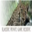

Corpus label: 27 ==> crocodile
Top 5 results: [42 63 97 14 21] ==> ['leopard', 'porcupine', 'wolf', 'butterfly', 'chimpanzee']
Image 7020:


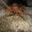

Corpus label: 26 ==> crab
Top 5 results: [45 26 79 56 44] ==> ['lobster', 'crab', 'spider', 'palm_tree', 'lizard']


In [62]:
for idx in cl_alg1_results.sample(10).index:
    result_report(cl_alg1_results, cifar100_test, idx)

### CL Algorithm 2: Prune by class

Use $n*(\text{row_sum}(Q))$ and choose the $n$ lowest self_confidence values from each labeled class

In [63]:
# Multiply Q matrix by a constant to get the number of items to 
# prune from each cell.
# Here we pick the constant value so as to produce the target number
# of examples.
# TODO: Double-check whether the Confident Learning paper chooses
# a particular value for this constant.
tunable_constant = 101
num_to_prune_matrix = q_matrix * tunable_constant

# Convert back to sparse representation
num_to_prune_matrix_ijv = (
    num_to_prune_matrix
    .melt(ignore_index=False)
    .reset_index())

# Drop all cells where the count rounds to zero or where the model's prediction
# agrees with the Confident Learning recommended value.
num_to_prune_matrix_ijv = (
    num_to_prune_matrix_ijv[
        (num_to_prune_matrix_ijv["value"] > 0)
        & (num_to_prune_matrix_ijv["top1"] != num_to_prune_matrix_ijv["cl_pred"])
    ])

# Sum by predicted class to get the number of items to prune from each 
# predicted class.
num_to_prune = (
    num_to_prune_matrix_ijv
    .groupby("top1")
    .agg({"value" : "sum"})
    .rename(columns={"value": "how_many"})
    .round().astype(int))

num_to_prune.sum()

how_many    10
dtype: int64

In [64]:
# Find the <num to prune> elements with the lowest self confidence for
# each label.
to_drop_list = []
for label, rows in  model_results.groupby("top1"):
    how_many = num_to_prune.loc[label][0]
    if how_many > 0:
        to_drop_list.append(rows.nsmallest(how_many, "top1_prob"))
cl_alg2_results = pd.concat(to_drop_list)        
cl_alg2_results

,id,probs,label,label_prob,top1,top1_prob,top5,top5_match,cl_pred,cl_normalized_margin,cl_predicted_on
8820,8820,"[ 0.004602137831825489, 0.0046721347898266...",45,0.037278,4,0.099690,"[ 4, 56, 74, 26, 45]",True,45,0.037278,False
7780,7780,"[ 0.003082934087638543, 0.002964749691396565...",40,0.037079,16,0.105850,"[16, 84, 61, 87, 40]",True,40,0.037079,False
617,617,"[ 0.0054110910550483815, 0.00295003131532808...",33,0.029644,18,0.124975,"[18, 51, 12, 44, 55]",False,33,0.029644,False
8897,8897,"[ 0.02328545197883238, 0.02407598727986401...",2,0.012854,26,0.076170,"[26, 36, 53, 62, 31]",False,2,0.012854,False
2370,2370,"[ 0.010793093292853889, 0.0084291921457189...",64,0.042876,27,0.122619,"[27, 74, 66, 73, 97]",False,64,0.042876,False
8549,8549,"[ 0.0023991610887293957, 0.002516194721046172...",51,0.020308,34,0.131668,"[34, 6, 88, 80, 45]",False,51,0.020308,False
6185,6185,"[0.00020127017479888606, 0.01550341717213425...",80,0.023941,38,0.132912,"[38, 34, 65, 32, 93]",False,80,0.023941,False
2833,2833,"[ 0.006013722650807262, 0.0207188956486122...",84,0.004888,40,0.080561,"[40, 30, 76, 10, 21]",False,84,0.004888,False
7557,7557,"[ 0.0029978227966824893, 0.003497368326457422...",80,0.014373,55,0.094238,"[55, 9, 46, 16, 40]",False,80,0.014373,False
5160,5160,"[ 0.0012248147221870492, 0.0162889277861885...",45,0.026031,83,0.140339,"[83, 29, 57, 18, 44]",False,45,0.026031,False


Image 8820:


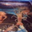

Corpus label: 45 ==> lobster
Top 5 results: [ 4 56 74 26 45] ==> ['beaver', 'palm_tree', 'shrew', 'crab', 'lobster']
Image 7780:


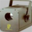

Corpus label: 40 ==> lamp
Top 5 results: [16 84 61 87 40] ==> ['can', 'table', 'plate', 'television', 'lamp']
Image 617:


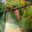

Corpus label: 33 ==> forest
Top 5 results: [18 51 12 44 55] ==> ['caterpillar', 'mushroom', 'bridge', 'lizard', 'otter']
Image 8897:


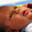

Corpus label: 2 ==> baby
Top 5 results: [26 36 53 62 31] ==> ['crab', 'hamster', 'orange', 'poppy', 'elephant']
Image 2370:


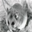

Corpus label: 64 ==> possum
Top 5 results: [27 74 66 73 97] ==> ['crocodile', 'shrew', 'raccoon', 'shark', 'wolf']
Image 8549:


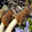

Corpus label: 51 ==> mushroom
Top 5 results: [34  6 88 80 45] ==> ['fox', 'bee', 'tiger', 'squirrel', 'lobster']
Image 6185:


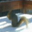

Corpus label: 80 ==> squirrel
Top 5 results: [38 34 65 32 93] ==> ['kangaroo', 'fox', 'rabbit', 'flatfish', 'turtle']
Image 2833:


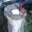

Corpus label: 84 ==> table
Top 5 results: [40 30 76 10 21] ==> ['lamp', 'dolphin', 'skyscraper', 'bowl', 'chimpanzee']
Image 7557:


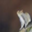

Corpus label: 80 ==> squirrel
Top 5 results: [55  9 46 16 40] ==> ['otter', 'bottle', 'man', 'can', 'lamp']
Image 5160:


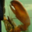

Corpus label: 45 ==> lobster
Top 5 results: [83 29 57 18 44] ==> ['sweet_pepper', 'dinosaur', 'pear', 'caterpillar', 'lizard']


In [65]:
for idx in cl_alg2_results.index:
    result_report(cl_alg2_results, cifar100_test, idx)

### CL Algorithm 3: Prune by Noise Rate

choose $n*Q_{i, j}$ for each bin: (y&#771; =i, y<super> *</super>=j)

In [66]:
# Constant `n`, chosen here to produce roughly the same number of values
# as algorithm 1.
# TODO: Check the Confident Learning paper to see if there's a different
# recommended way to choose this value.
tunable_constant = 420

# Convert `q_matrix` to sparse format and drop cells where the model agrees
# with the CL predicted value or there are zero examples.
q_matrix_ijv = (
    q_matrix
    .melt(ignore_index=False)
    .reset_index())
num_to_flag_df = (
    q_matrix_ijv[
        (q_matrix_ijv["value"] > 0)
        & (q_matrix_ijv["top1"] != q_matrix_ijv["cl_pred"])]
    .rename(columns={"value": "how_many"}))
num_to_flag_df["how_many"] *= tunable_constant
num_to_flag_df["how_many"] = num_to_flag_df["how_many"].round().astype(int)
num_to_flag_df = num_to_flag_df[num_to_flag_df["how_many"] > 0]

# Convert to a dictionary from (top1, cl_pred) to number of 
# low-self-confidence values to flag.
num_to_flag_dict = {
    (row["top1"], row["cl_pred"]): row["how_many"]
    for _, row in num_to_flag_df.iterrows()
}

# Flag the indicated number of items from each category.
to_flag_list = []
for labels, rows in  model_results.groupby(["top1", "cl_pred"]):
    if labels in num_to_flag_dict:
        how_many = num_to_flag_dict[labels]
        to_flag_list.append(rows.nsmallest(how_many, "top1_prob"))
cl_alg3_results = pd.concat(to_flag_list)        
cl_alg3_results

,id,probs,label,label_prob,top1,top1_prob,top5,top5_match,cl_pred,cl_normalized_margin,cl_predicted_on
4157,4157,"[ 0.006674588118552838, 0.00140230156304649...",55,0.048394,4,0.107252,"[ 4, 91, 51, 15, 30]",False,55,0.048394,False
1917,1917,"[0.00021368968491387028, 0.000855350801277641...",24,0.140818,7,0.346824,"[ 7, 79, 24, 6, 77]",True,24,0.140818,False
1290,1290,"[ 0.0005030155444030151, 0.000509549966756746...",79,0.152476,26,0.326207,"[26, 79, 7, 15, 74]",True,79,0.152476,False
5237,5237,"[ 0.0030494240937424437, 0.000354311973680319...",52,0.238060,47,0.263119,"[47, 52, 56, 96, 59]",True,52,0.238060,False
7179,7179,"[ 0.002233781383507679, 0.00651043902525428...",83,0.066360,53,0.198624,"[53, 3, 36, 83, 39]",True,83,0.066360,False
4839,4839,"[ 0.025125647136667758, 0.00765981579854305...",83,0.209145,57,0.279943,"[57, 83, 50, 92, 54]",True,83,0.209145,False
8408,8408,"[ 0.0013231324783536725, 0.00091725060422752...",47,0.032883,59,0.252202,"[59, 37, 52, 96, 17]",False,47,0.032883,False
6345,6345,"[ 0.0019314142571165884, 0.000343260346301297...",23,0.269950,71,0.503069,"[71, 23, 60, 49, 69]",True,23,0.269950,False
5533,5533,"[ 0.0013173763631694722, 0.00124035629033506...",81,0.073515,90,0.283741,"[90, 89, 81, 7, 12]",True,81,0.073515,False
5967,5967,"[ 0.001413876239257872, 0.000906821130538720...",62,0.210811,92,0.333204,"[92, 54, 62, 70, 82]",True,62,0.210811,False


Image 4157:


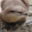

Corpus label: 55 ==> otter
Top 5 results: [ 4 91 51 15 30] ==> ['beaver', 'trout', 'mushroom', 'camel', 'dolphin']
Image 1917:


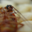

Corpus label: 24 ==> cockroach
Top 5 results: [ 7 79 24  6 77] ==> ['beetle', 'spider', 'cockroach', 'bee', 'snail']
Image 1290:


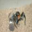

Corpus label: 79 ==> spider
Top 5 results: [26 79  7 15 74] ==> ['crab', 'spider', 'beetle', 'camel', 'shrew']
Image 5237:


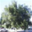

Corpus label: 52 ==> oak_tree
Top 5 results: [47 52 56 96 59] ==> ['maple_tree', 'oak_tree', 'palm_tree', 'willow_tree', 'pine_tree']
Image 7179:


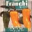

Corpus label: 83 ==> sweet_pepper
Top 5 results: [53  3 36 83 39] ==> ['orange', 'bear', 'hamster', 'sweet_pepper', 'keyboard']
Image 4839:


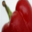

Corpus label: 83 ==> sweet_pepper
Top 5 results: [57 83 50 92 54] ==> ['pear', 'sweet_pepper', 'mouse', 'tulip', 'orchid']
Image 8408:


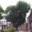

Corpus label: 47 ==> maple_tree
Top 5 results: [59 37 52 96 17] ==> ['pine_tree', 'house', 'oak_tree', 'willow_tree', 'castle']
Image 6345:


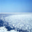

Corpus label: 23 ==> cloud
Top 5 results: [71 23 60 49 69] ==> ['sea', 'cloud', 'plain', 'mountain', 'rocket']
Image 5533:


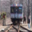

Corpus label: 81 ==> streetcar
Top 5 results: [90 89 81  7 12] ==> ['train', 'tractor', 'streetcar', 'beetle', 'bridge']
Image 5967:


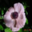

Corpus label: 62 ==> poppy
Top 5 results: [92 54 62 70 82] ==> ['tulip', 'orchid', 'poppy', 'rose', 'sunflower']


In [67]:
for idx in cl_alg3_results.index:
    result_report(cl_alg3_results, cifar100_test, idx)

### Alternate approach

In [68]:
# def compute_num_wrong(reg_coeff: float) -> int:
#     # For this solver, the regularization coeff is 1/penalty, so smaller values
#     # mean more regularization
#     inverse_reg_coeff = 1 / reg_coeff
#     model = train_base_model(train, regularization_coeff=inverse_reg_coeff)
#     results = make_results(train, model)
#     num_wrong = (results["label"] != results["top1"]).sum()
#     print(f"Num wrong at {reg_coeff:1.1e}: {num_wrong}")
#     return num_wrong


# num_coeffs = 200
# coeffs = np.logspace(1, 8, num_coeffs)
# wrong_counts = [compute_num_wrong(c) for c in coeffs]
# print(wrong_counts)

In [69]:
# plt.xscale("log")
# plt.scatter(coeffs, wrong_counts)
# plt.show()
# pass

In [70]:
# Skip this old code -- it doesn't work.

# def compute_num_wrong_2(num_dims: int, reg_coeff: float) -> int:
#     # For this solver, the regularization coeff is 1/penalty, so smaller values 
#     # mean more regularization
#     inverse_reg_coeff = 1 / reg_coeff
#     model = train_reduced_model(train, num_dims, regularization_coeff=inverse_reg_coeff)
#     results = make_results(train, model)
#     num_wrong = (results["label"] != results["top1"]).sum()
#     print(f"Num wrong at {num_dims} / {reg_coeff:1.1f}: {num_wrong}")
#     return num_wrong

    
# num_points = 200
# nums_of_dims = np.logspace(np.log10(1792), 1, num_points).astype(int)
# reg_coeff = 1e7

# wrong_counts_2 = [compute_num_wrong_2(n, reg_coeff) for n in nums_of_dims]
# print(wrong_counts_2)

# plt.xscale("log")
# plt.scatter(nums_of_dims, wrong_counts_2)
# plt.show()
# pass